# Deep Learning - Lista 1

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import math


from numpy.random.mtrand import uniform, randint

from sklearn import preprocessing
from sklearn import multiclass
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 1° Questão:

A representação de uma determinada mensagem digital ternária, isto é formada por três bits, forma um cubo cujos vértices correspondem a mesma representação digital. Supondo que ao transmitirmos esta mensagem a mesma possa ser contaminada por ruído formado em torno de cada vértice uma nuvem esférica de valores aleatórios com raio máximo é 0.1. Formule este problema como um problema de classificação de padrões e treine uma rede Perceptron de
Rosenblatt (Perceptron de camada única) para atuar como classificador/decodificador. Para solução do problema defina antes um conjunto de treinamento e um conjunto de validação. 

Dica: O problema pode ser formulado como um problema de classificação de 8 padrões diferentes, sendo que cada padrão representa um vértice do cubo.

### Geração De Instâncias

In [ ]:
def generate_instances(size):
  instances = []
  for i in range(size):
    v1, v2, v3 = randint(100, size=3)%2
    instance = {'v1': v1 + uniform(-0.1,0.1), 'v2': v2 + uniform(-0.1,0.1), 'v3': v3 + uniform(-0.1,0.1), 'c': v1*4+v2*2+v3*1}
    instances.append(instance)

  instances = pd.DataFrame(instances)
  classes = pd.DataFrame(preprocessing.OneHotEncoder().fit_transform(instances[['c']]).toarray())
  
  instances = instances.drop('c', axis=1)
  instances = instances.join(classes)

  return instances

df = generate_instances(1000)
print(df)

           v1        v2        v3    0    1    2    3    4    5    6    7
0   -0.075947  0.990903  0.994455  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
1    1.069069 -0.060079  0.050972  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2    0.996149  1.068255 -0.099050  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
3   -0.058956  1.016289  1.013870  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
4    0.003777  0.073137  0.017215  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
..        ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...
995  1.046501 -0.030764 -0.051851  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
996  1.077706  1.085677  0.971372  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
997  0.089707 -0.090718  0.070649  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
998  1.038824  0.960443  0.069457  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
999  0.933308  1.082298 -0.031970  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0

[1000 rows x 11 columns]


### Treinamento

In [ ]:
train, test = model_selection.train_test_split(df.copy(), test_size = 0.2, random_state = 77, shuffle = True)
X_train, y_train = train[train.columns[:3]], train[train.columns[3:]]
X_test, y_test = test[test.columns[:3]], test[test.columns[3:]]

perceptron = multiclass.OneVsRestClassifier(linear_model.Perceptron())
perceptron.fit(X_train, y_train)

y_pred = perceptron.predict(X_test)

### Metricas

In [ ]:
def getMetrics(y_true, y_pred, classes, plot = True):   
    totalSen = 0
    totalSpec = 0
    totalAcc = 0
    results = []

    matrix = metrics.multilabel_confusion_matrix(y_true, y_pred)
    #for each class
    for i in range(len(matrix)):
        [[true_negative, false_positive], [false_negative, true_positive]] = matrix[i]
        sen = (true_positive / (true_positive + false_negative))
        sp = (true_negative / (true_negative + false_positive))
        acc = ((true_positive + true_negative) / (true_positive + false_negative + true_negative + false_positive))
        totalSen += sen
        totalSpec += sp
        totalAcc += acc
        results.append({"Label": classes[i], "Sensibilidade": sen, "Especificidade": sp, "Acuracia": acc})
    
    if plot is True:
        pd.DataFrame(results).plot.bar(x = "Label")

    print("Media dos valores:")
    print("\tF1: %0.3f" % (metrics.f1_score(y_test, y_pred, average = 'macro')))
    print("\tSensibilidade: %0.3f" % (totalSen / len(matrix)))
    print("\tEspecificidade: %0.3f" % (totalSpec / len(matrix)))
    print("\tAcuracia: %0.3f" % (metrics.accuracy_score(y_test, y_pred, normalize = True)))
    print("\tMedia acuracia (individual): %0.3f\n" % (totalAcc / len(matrix)))
    

Media dos valores:
	F1: 1.000
	Sensibilidade: 1.000
	Especificidade: 1.000
	Acuracia: 1.000
	Media acuracia (individual): 1.000



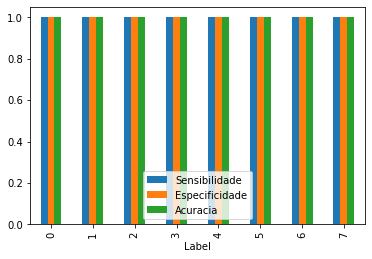

In [ ]:
getMetrics(y_test, y_pred, df.columns[3:])

## 2° Questão:

Implemente uma rede perceptron de múltiplas camadas e utilize-a para aproximar as funções abaixo. Em seguida, compare os resultados com as curvas exatas. No caso das letras (b) e (c), apresente também a curva do erro médio de treinamento com relação ao número de épocas e a curva do erro médio com o conjunto de validação.

### a) A função lógica XOR

#### Geração de Instâncias

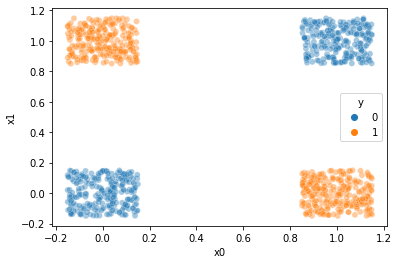

In [ ]:
def generate_instances(size):
  instances = []
  for i in range(size):
    x0 = randint(2) + uniform(-0.15,0.15)
    x1 = randint(2) + uniform(-0.15,0.15)
    instance = {'x0': x0, 'x1': x1, 'y': round(x0)^round(x1)}
    instances.append(instance)

  instances = pd.DataFrame(instances)
  return instances

df = generate_instances(1000)

sns.scatterplot(data=df[['x0', 'x1', 'y']], x='x0', y='x1', hue='y', alpha=0.4)

#### Treinamento

In [ ]:
train, test = model_selection.train_test_split(df.copy(), test_size = 0.2, random_state = 77, shuffle = True)

X_train, y_train = train.drop('y', axis=1), train.drop(['x0','x1'], axis=1)
X_test, y_test = test.drop('y', axis=1), test.drop(['x0','x1'], axis=1)

model = keras.Sequential()
model.add(layers.Input(2))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25)

predictor = model.fit(X_train, y_train, epochs=250, batch_size=10, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/250
64/64 [==============================] - 0s 3ms/step - loss: 0.3497 - mse: 0.3497 - val_loss: 0.3309 - val_mse: 0.3309
Epoch 2/250
64/64 [==============================] - 0s 1ms/step - loss: 0.2699 - mse: 0.2699 - val_loss: 0.2747 - val_mse: 0.2747
Epoch 3/250
64/64 [==============================] - 0s 1ms/step - loss: 0.2311 - mse: 0.2311 - val_loss: 0.2421 - val_mse: 0.2421
Epoch 4/250
64/64 [==============================] - 0s 2ms/step - loss: 0.2075 - mse: 0.2075 - val_loss: 0.2202 - val_mse: 0.2202
Epoch 5/250
64/64 [==============================] - 0s 2ms/step - loss: 0.1916 - mse: 0.1916 - val_loss: 0.2051 - val_mse: 0.2051
Epoch 6/250
64/64 [==============================] - 0s 2ms/step - loss: 0.1801 - mse: 0.1801 - val_loss: 0.1930 - val_mse: 0.1930
Epoch 7/250
64/64 [==============================] - 0s 2ms/step - loss: 0.1701 - mse: 0.1701 - val_loss: 0.1811 - val_mse: 0.1811
Epoch 8/250
64/64 [==============================] - 0s 2ms/step - loss: 0.1584 - m

#### Metricas

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 4)                 12        
                                                                 
 dense_34 (Dense)            (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


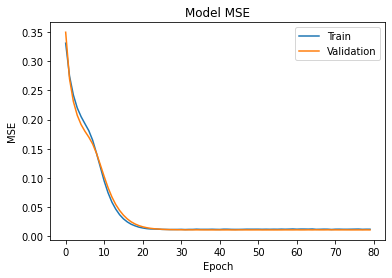

In [ ]:
plt.plot(predictor.history['val_loss'])
plt.plot(predictor.history['loss'])
plt.title('MSE Progression')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'])

In [ ]:
y_test_predicted = model.predict(X_test)
#print(y_test_predicted)
y_test_predicted = [round(i[0]) for i in y_test_predicted]
#print(y_test_predicted)
print(metrics.classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00       106

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



### b) f(x) = log10 (x), onde 1 ≤ x ≤ 10

#### Geração de Instâncias

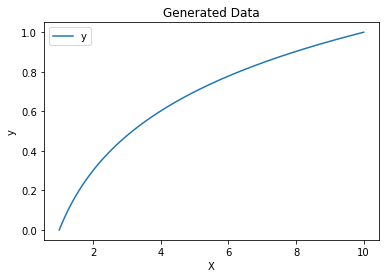

In [ ]:
def generate_instances(size):
  instances = []
  for i in range(size):
    x = uniform(1,10)
    instance = {'x': x, 'y': math.log10(x)}
    instances.append(instance)

  instances = pd.DataFrame(instances)
  return instances

df = generate_instances(1000)

df_aux = df.sort_values(by=['x'])
plt.plot(df_aux['x'], df_aux['y'])
plt.title('Generated Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(['y'])

#### Treinamento

In [ ]:
train, test = model_selection.train_test_split(df.copy(), test_size = 0.2, random_state = 77, shuffle = True)

X_train, y_train = train['x'], train['y']
X_test, y_test = test['x'], test['y']

model = keras.Sequential()
model.add(layers.Input(1))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25)

predictor = model.fit(X_train, y_train, epochs=200, batch_size=25, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/200
560/560 [==============================] - 1s 2ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 2/200
560/560 [==============================] - 1s 1ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 3/200
560/560 [==============================] - 1s 2ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 4/200
560/560 [==============================] - 1s 1ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 5/200
560/560 [==============================] - 1s 2ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 7.6454e-04 - val_mse: 7.6454e-04
Epoch 6/200
560/560 [==============================] - 1s 2ms/step - loss: 5.3686e-04 - mse: 5.3686e-04 - val_loss: 4.6407e-04 - val_mse: 4.6407e-04
Epoch 7/200
560/560 [==============================] - 1s 2ms/step - loss: 4.0002e-04 - mse: 4.0002e-04 - val_loss: 3.9746e-04 - val_mse: 3.9746e-04
Epoch 8/200
560/560 [========

#### Metricas

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 4)                 8         
                                                                 
 dense_36 (Dense)            (None, 8)                 40        
                                                                 
 dense_37 (Dense)            (None, 1)                 9         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


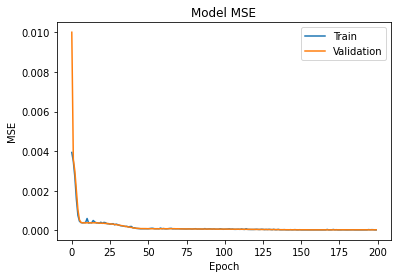

In [ ]:
plt.plot(predictor.history['val_loss'])
plt.plot(predictor.history['loss'])
plt.title(' MSE Progression')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'])

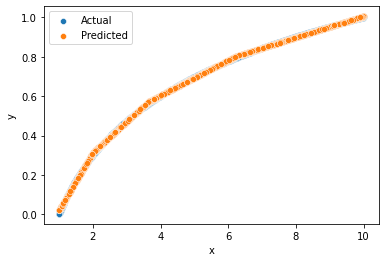

In [ ]:
y_pred = model.predict(X_test)
y_pred_df = pd.Series(data=[i[0] for i in y_pred], index=X_test.index)

sns.scatterplot(x=X_test, y=y_test)
sns.scatterplot(x=X_test, y=y_pred_df)
plt.legend(['Actual', 'Predicted'])

### c) f(x) = 10x^5 + 5x^4+ 2x^3– 0.5x^2+ 3x + 2, onde 0 ≤ x ≤ 20

#### Geração de Instâncias

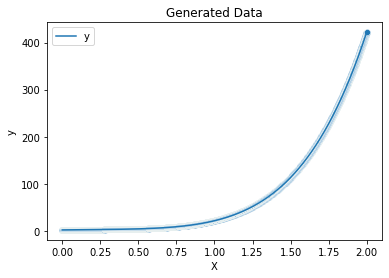

In [ ]:
f = lambda x : 10*(x**5) + 5*(x**4) + 2*(x**3) - 0.5*(x**2) + 3*x + 2

def generate_instances(size):
  instances = []
  for i in range(size):
    x = uniform(0,2)
    instance = {'x': x, 'y': f(x)}
    instances.append(instance)

  instances = pd.DataFrame(instances)
  return instances

df = generate_instances(10000)

df_aux = df.sort_values(by=['x'])
plt.plot(df_aux['x'], df_aux['y'])
plt.title('Generated Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(['y'])

#sns.scatterplot(x=df_aux['x'], y=df_aux['y'])

#### Treinamento

In [ ]:
train, test = model_selection.train_test_split(df.copy(), test_size = 0.2, random_state = 77, shuffle = True)

X_train, y_train = train['x'], train['y']
X_test, y_test = test['x'], test['y']

model = keras.Sequential()
model.add(layers.Input(1))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(8, activation='sigmoid'))
model.add(layers.Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
predictor = model.fit(X_train, y_train, epochs=1500, batch_size=128, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/1500
44/44 [==============================] - 1s 5ms/step - loss: 17713.3965 - mse: 17713.3965 - val_loss: 18260.0625 - val_mse: 18260.0625
Epoch 2/1500
44/44 [==============================] - 0s 2ms/step - loss: 17641.6582 - mse: 17641.6582 - val_loss: 18167.3457 - val_mse: 18167.3457
Epoch 3/1500
44/44 [==============================] - 0s 2ms/step - loss: 17536.1875 - mse: 17536.1875 - val_loss: 18046.1250 - val_mse: 18046.1250
Epoch 4/1500
44/44 [==============================] - 0s 2ms/step - loss: 17424.8965 - mse: 17424.8965 - val_loss: 17941.8789 - val_mse: 17941.8789
Epoch 5/1500
44/44 [==============================] - 0s 2ms/step - loss: 17339.5254 - mse: 17339.5254 - val_loss: 17868.1699 - val_mse: 17868.1699
Epoch 6/1500
44/44 [==============================] - 0s 2ms/step - loss: 17278.2227 - mse: 17278.2227 - val_loss: 17813.2871 - val_mse: 17813.2871
Epoch 7/1500
44/44 [==============================] - 0s 2ms/step - loss: 17230.2754 - mse: 17230.2754 - val_los

#### Metricas

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 16)                32        
                                                                 
 dense_39 (Dense)            (None, 12)                204       
                                                                 
 dense_40 (Dense)            (None, 8)                 104       
                                                                 
 dense_41 (Dense)            (None, 1)                 9         
                                                                 
Total params: 349
Trainable params: 349
Non-trainable params: 0
_________________________________________________________________


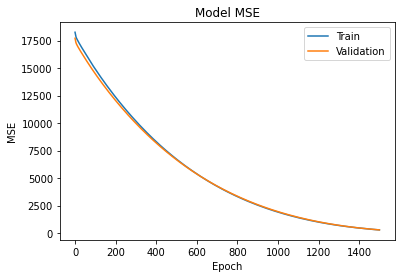

In [ ]:
plt.plot(predictor.history['val_loss'])
plt.plot(predictor.history['loss'])
plt.title('MSE Progression')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'])

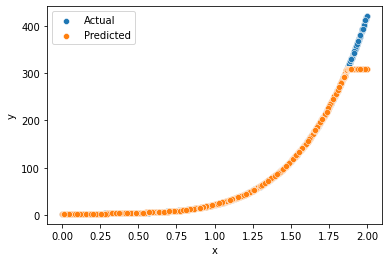

In [ ]:
y_pred = model.predict(X_test)
y_pred_df = pd.Series(data=[i[0] for i in y_pred], index=X_test.index)

sns.scatterplot(x=X_test, y=y_test)
sns.scatterplot(x=X_test, y=y_pred_df)
plt.legend(['Actual', 'Predicted'])